# CSE 40 Take-Home Final: jrhuecke

Your unique dataset consists of physiochemical properties of a selection of Portuguese Vinho Verde wines.

Some wines are red, some are white. A boolean label for high-quality white wines has been provided.

You are free to use any library code provided within the `cse40` conda environment.

In [1007]:
import re

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from scipy import stats

# You may import sklearn models of your choosing. For example,
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

df = pd.read_csv('data.csv')

df.head()

,chlorides,fixed acidity,pH,sulphates,volatile acidity,quality white
0,0.048 g(sodium chloride)/dm^3,8.4 g(tartaric acid)/dm^3,3.40,0.46 g(potassium sulphate)/dm^3,0.28 g(acetic acid)/dm^3,False
1,0.073 g(sodium chloride)/dm^3,6.9 g(tartaric acid)/dm^3,3.45,0.52 g(potassium sulphate)/dm^3,0.605 g(acetic acid)/dm^3,False
2,0.092 g(sodium chloride)/dm^3,8.8 g(tartaric acid)/dm^3,3.19,0.52 g(potassium sulphate)/dm^3,0.42 g(acetic acid)/dm^3,False
3,0.031 g(sodium chloride)/dm^3,6.6 g(tartaric acid)/dm^3,3.17,0.58 g(potassium sulphate)/dm^3,0.17 g(acetic acid)/dm^3,True
4,0.076 g(sodium chloride)/dm^3,8.3 g(tartaric acid)/dm^3,3.26,0.7 g(potassium sulphate)/dm^3,0.26 g(acetic acid)/dm^3,False


In [1008]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   chlorides         998 non-null    object 
 1   fixed acidity     1000 non-null   object 
 2   pH                1000 non-null   float64
 3   sulphates         999 non-null    object 
 4   volatile acidity  1000 non-null   object 
 5   quality white     1000 non-null   bool   
dtypes: bool(1), float64(1), object(4)
memory usage: 40.2+ KB


# Step 1
I first cleaned up the data by extracting the important information out of each column so that every element is just a number and all the columns have type float. This allows for actual interpretation of the data later.

In [1009]:
def extract_first_number(source_str):
    '''
    extract the first numerical value appearing in a string
    as a float and return it, allowing negative numbers and 
    decimal values
    '''
    
    # `source_str` does not contain interpretable data
    if pd.isna(source_str) or source_str.startswith('NA'):
        
        # use `np.nan` to represent missing data
        return np.nan

    # find instances of a valid numerical substrings in the source string
    matches = re.search(r'-?\d+\.?\d*', source_str.replace(',', ''))
    
    # if there are any valid numerical substrings
    if matches:
        return float(matches[0]) # convert the first one to a float and return the value
    else:
        return np.nan # otherwise, treat as missing data
    
def clean_elements(df, exclude_columns=[]):
    '''
    Converts the columns of a dataframe from strings containing numbers to
    the first number appearing in each string.
    
    Args:
        df: A pandas dataframe
        exclude_columns: A list of columns that should not be converted
        
    Returns:
        A pandas dataframe
    '''
    
    #goes through each element in the dataset, replacing them with the 1st number in their string
    for c in df.columns:
        if c not in exclude_columns:
            for i in df.index:
                df.at[i, c] = extract_first_number(df.at[i,c])    
        else:
            pass
        
    return df


df = clean_elements(df, ['pH', 'quality white'])

#changing all the column types to float64
df['chlorides'] = pd.to_numeric(df['chlorides'])
df['fixed acidity'] = pd.to_numeric(df['fixed acidity'])
df['sulphates'] = pd.to_numeric(df['sulphates'])
df['volatile acidity'] = pd.to_numeric(df['volatile acidity'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   chlorides         998 non-null    float64
 1   fixed acidity     1000 non-null   float64
 2   pH                1000 non-null   float64
 3   sulphates         999 non-null    float64
 4   volatile acidity  1000 non-null   float64
 5   quality white     1000 non-null   bool   
dtypes: bool(1), float64(5)
memory usage: 40.2 KB


# Step 2
I then got rid of all rows containing missing data. Given that this only sacrifices 3 of the 1000 rows, I feel like it was worth it simply for the ease of working with the dataset later.

In [1010]:
def drop_na_rows(df):
    '''
    Args:
        df: A pandas dataframe
        
    Returns:
        The DataFrame with all rows that have missing data removed        
    '''
    
    #iterates through each element in each row, dropping the row if there is missing data
    for row in df.index:
        for col in df.columns:
            if(pd.isna(df.at[row, col])):
                df = df.drop(index=[row])
                break
                
    return df

df = drop_na_rows(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 997 entries, 0 to 999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   chlorides         997 non-null    float64
 1   fixed acidity     997 non-null    float64
 2   pH                997 non-null    float64
 3   sulphates         997 non-null    float64
 4   volatile acidity  997 non-null    float64
 5   quality white     997 non-null    bool   
dtypes: bool(1), float64(5)
memory usage: 80.0 KB


# Step 3
Next, by using the corrwith pandas function I was able to find two columns (fixed acidity and pH) which have minimal impact on quality white. I dropped them to simplify the data set.

In [1011]:
print(df.corrwith(df['quality white'], axis = 0))
df = df.drop(columns=['fixed acidity'])
df = df.drop(columns=['pH'])
df.head()

chlorides          -0.310717
fixed acidity      -0.029779
pH                 -0.059198
sulphates          -0.199799
volatile acidity   -0.463421
quality white       1.000000
dtype: float64


,chlorides,sulphates,volatile acidity,quality white
0,0.048,0.46,0.280,False
1,0.073,0.52,0.605,False
2,0.092,0.52,0.420,False
3,0.031,0.58,0.170,True
4,0.076,0.70,0.260,False


# Step 4
At this point I wanted to actually check the balance of the data between quality/not-quality. It ended up being fairly even with 47% being True so I was happy with that.

In [1012]:
false = 0
true = 0
#going through each element in the row 'quality white' counting the true/false
for row in df.index:
    if (df.at[row, 'quality white'] == True):
        true += 1
    else:
        false += 1

print("True:", true, "False:", false)
print("Percent Quality:", 100 * true/997)

True: 476 False: 521
Percent Quality: 47.7432296890672


# Step 5
To further my understanding of the data, I used Matplotlib to make some graphs comparing some of the columns. I focused mostly on the relationship between volatile acidity with other columns because that was the feature shown to have the greatest negative connotation to quality white in Step 3. 

The blue graph comparing volatile acidity to chlorides shows that as volatile acidity increases, chlorides also slightly increases, but it also shows that there were some pretty extreme chlorides outliers which I ended up removing in the next step. 

The red graph comparing volatile acidity to quality white was pretty inline with what corrwith showed in Step 3. The higher volatile acidity is, the greater chance of quality white being false. 

The last graph which plots the relation between sulphates and quality white shows that while there is slight negative correlation, sulphates does not have too much impact on quality white being true. This also lines up with what was found in Step 3.

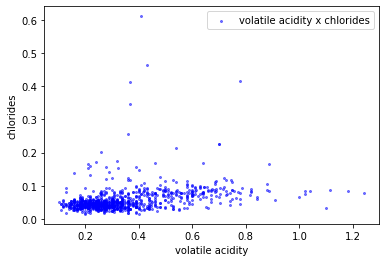

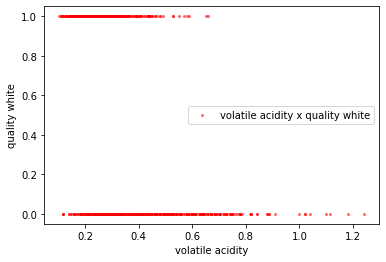

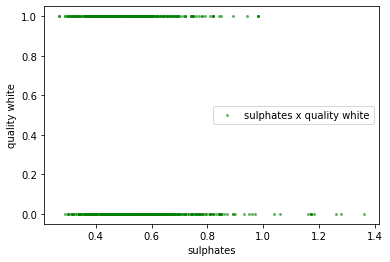

In [1013]:
#Making 1st graph
fig = plt.figure()
ax1 = fig.add_subplot(111)


ax1.set_xlabel('volatile acidity')
ax1.set_ylabel('chlorides')

ax1.scatter(df['volatile acidity'], df['chlorides'], s=4, c='b', alpha=0.5, label='volatile acidity x chlorides')

plt.legend();
plt.show()

#Making 2nd graph
fig = plt.figure()
ax2 = fig.add_subplot(111)

ax2.set_xlabel('volatile acidity')
ax2.set_ylabel('quality white')

ax2.scatter(df['volatile acidity'], df['quality white'], s=4, c='r', alpha=0.5, label='volatile acidity x quality white')

plt.legend();
plt.show()

#Making 3rd graph
fig = plt.figure()
ax3 = fig.add_subplot(111)


ax3.set_xlabel('sulphates')
ax3.set_ylabel('quality white')

ax3.scatter(df['sulphates'], df['quality white'], s=4, c='g', alpha=0.5, label='sulphates x quality white')

plt.legend();
plt.show()

# Step 6
To make the data set even better, I got rid of the rows containing more extreme chloride outliers based on what was found in the previous step. This ended up removing 5 more rows, but since those rows contained major outliers I figured it would worth it to get rid of them. I also redid the volatile acidity x chlorides graph and this time around it is much easier to see that on average chlorides increase when volatile acidity increases or vice versa.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 992 entries, 0 to 999
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   chlorides         992 non-null    float64
 1   sulphates         992 non-null    float64
 2   volatile acidity  992 non-null    float64
 3   quality white     992 non-null    bool   
dtypes: bool(1), float64(3)
memory usage: 64.3 KB


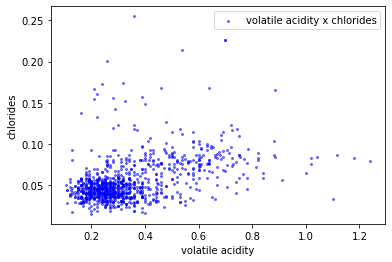

In [1014]:
for row in df.index:
    if (df.at[row, 'chlorides'] > 0.3):
        df = df.drop(index=[row])
df.info()

#Making 1st graph
fig = plt.figure()
ax1 = fig.add_subplot(111)


ax1.set_xlabel('volatile acidity')
ax1.set_ylabel('chlorides')

ax1.scatter(df['volatile acidity'], df['chlorides'], s=4, c='b', alpha=0.5, label='volatile acidity x chlorides')

plt.legend();
plt.show()


# Step 7
At this point I actually started testing models on the data. Below defines the function for doing K Fold Validations that returns test scores for 3 different models. When using a K value of 5 the Decision Tree model has the highest accuracy on average, but the Linear model ends up having a pretty extreme outlier giving it a very large standard deviation. So I redid the K Fold Validation with a K value of 6 in hopes of getting some better averages across the board which ended up being somewhat succesful! The Linear model's average score shot up a good bit with the other two model's scores on being slightly affected. Because of that I decided to use k=6 for future steps to have a better comparison between the models.

In [1015]:
#defining the models
linear_model = SGDClassifier(
    loss='log',
    random_state=0
)
tree_model = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=3,
    random_state=0
)
knn_model = KNeighborsClassifier(
    n_neighbors=5
)

models = {
    'linear': linear_model,
    'tree': tree_model, 
    'KNN': knn_model
}

#picking the features to do the K Fold Validation on
features = ['chlorides', 'sulphates', 'volatile acidity']
label = ['quality white']

X, y = df[features], df[label] > 0

def K_Fold_Validate(models, kf, X, y):
    # flatten the pandas Series to a simple numpy array
    # so sklearn doesn't complain about column vectors
    y = y.to_numpy().ravel() 
    
    # initialize dictionary to hold scores
    scores = {}
    
    #calls cross_validate for each model
    for name in models:
        scores[name] = cross_val_score(models[name], X, y, scoring='f1', cv=kf)
        
    return scores

#Computing/printing the scores for k=5
k = 5
kf = KFold(k)

print("Scores using k=5:")
scores = K_Fold_Validate(models, kf, X, y)
for k, v in scores.items():
    print(k, v)
    print('Average:', v.mean(axis=0), ' Standard Deviation:', v.std(axis=0))
    print()

#Computing/printing the scores for k=6
k = 6
kf = KFold(k)

print()
print("Scores using k=6:")
scores = K_Fold_Validate(models, kf, X, y)
for k, v in scores.items():
    print(k, v)
    print('Average:', v.mean(axis=0), ' Standard Deviation:', v.std(axis=0))
    print()

Scores using k=5:
linear [0.16494845 0.74626866 0.73417722 0.70873786 0.76470588]
Average: 0.6237676143890301  Standard Deviation: 0.23012837562052046

tree [0.71186441 0.6440678  0.74747475 0.75789474 0.78787879]
Average: 0.7298360951170941  Standard Deviation: 0.049288023344309206

KNN [0.69148936 0.75117371 0.69950739 0.69565217 0.71428571]
Average: 0.7104216695967269  Standard Deviation: 0.02177774714125065


Scores using k=6:
linear [0.4957265  0.6993007  0.75       0.76777251 0.72826087 0.69879518]
Average: 0.6899759595272742  Standard Deviation: 0.09038667577465773

tree [0.73825503 0.71856287 0.73684211 0.69512195 0.74172185 0.7375    ]
Average: 0.7280006364326416  Standard Deviation: 0.016491984193710053

KNN [0.71794872 0.74576271 0.78409091 0.72727273 0.75471698 0.6835443 ]
Average: 0.7355560585177175  Standard Deviation: 0.03138684197675111



# Step 8
For the final step in the process, I calculated the p-value for each model and graphed the f1 score comparison using K Fold Cross Validation with k=6 because of the results in the previous step.

prob. that avg. f1 score for linear and tree are the same: 0.13445890146330075
prob. that avg. f1 score for linear and knn are the same: 0.3994389737744947
prob. that avg. f1 score for knn and tree are the same: 0.6454027197782298


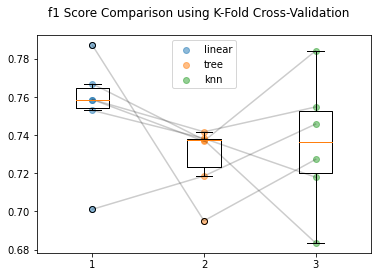

In [1016]:
def p_value(model1_scores, model2_scores):
    '''
    return probability of null hypothesis 
    (that points were sampled from same distribution)
    '''
    
    t = 0
    n = len(model1_scores)
    
    #solving for numerator
    for i in range(n):
        t += (1 / n) * (model1_scores[i] - model2_scores[i])
    
    #solving for denominator
    s = 0
    #caculate summation
    for i in range(n):
        s += (1 / n) * ((model1_scores[i] - model2_scores[i]) - t)**2  
    s = np.sqrt(s)
    s = s / np.sqrt(len(model1_scores) - 1)
    t = t / s
    
    # compute the pvalue from a two-tailed t-statistic `t`
    pval = stats.t.sf(np.abs(t), len(model1_scores)-1) * 2
    
    return pval

linear_model = SGDClassifier(
    loss='hinge',
    penalty='l1',
    random_state=0
)
tree_model = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=3,
    random_state=0
)
knn_model = KNeighborsClassifier(
    n_neighbors=5
)

models = {
    'linear': linear_model,
    'tree': tree_model, 
    'knn': knn_model
}

features = [c for c in df.columns if c != 'quality white']
label = ['quality white']

X, y = df[features], df[label] > 0

k = 6
kf = KFold(k)

scores = K_Fold_Validate(models, kf, X, y)


def report(a, b):
    pval = p_value(scores[a], scores[b])
    print(f'prob. that avg. f1 score for {a} and {b} are the same:', pval)

report('linear', 'tree')
report('linear', 'knn')
report('knn', 'tree')
    
# plot
fig = plt.figure()
fig.suptitle('f1 Score Comparison using K-Fold Cross-Validation')
ax = fig.add_subplot(111)
for i, (k, v) in enumerate(scores.items()):
    ax.scatter(i * np.ones(len(v)) + 1, v, label=k, alpha=0.5)
for i in range(len(scores['linear'])):
    ax.plot([1, 2, 3], [scores[k][i] for k in scores.keys()], c='k', alpha=0.2)
ax.boxplot(scores.values())
plt.legend()
plt.show()

# Final Analysis
Looking at the comparison between the average scores for each model it can be seen that K Nearest Neighbor and Decision Tree are the most similar by far. The Linear model has the lowest similarity with the other two models, which makes sense given that as seen in the results for Step 7, linear had a pretty weak first score.

So in the end by looking at the results for Steps 7/8 it appears that there is a bit of a tie in preformance between Decision Tree and KNN. If k=5 then KNN has a higher average score than Linear, but when k=6 those positions swap. And the averages for both cases only have a difference of ~1. This change was done in the first place to dramatically alter the Linear models preformance so maybe if I had increase K by more than Linear would have appeared to be the best one. This shows K Fold Validation can produce vastly different results based on the k value so it is important to test the data with a couple different k values to make sure to get truly accurate scores.

In the end I would probably decide on using the Decision Tree model for the dataset given its simplicity and how easy it is to understand.